In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
import random

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
G, target = sg.datasets.CiteSeer().load(largest_connected_component_only=True)

In [3]:
from stellargraph.data import UnsupervisedSampler, BiasedRandomWalk

samples = UnsupervisedSampler(G, nodes=list(G.nodes()), length=10, number_of_walks=4) # rw + run


In [4]:
from stellargraph.mapper import Attri2VecLinkGenerator

generator = Attri2VecLinkGenerator(G, batch_size=128)
flow = generator.flow(samples)

In [5]:
from stellargraph.layer import Attri2Vec

a2v = Attri2Vec(layer_sizes=[128, 128], generator=generator)

In [6]:
a2v.in_out_tensors()

([<tf.Tensor 'input_1:0' shape=(None, 3703) dtype=float32>,
  <tf.Tensor 'input_2:0' shape=(None, 1) dtype=float32>],
 [<tf.Tensor 'lambda_1/Identity:0' shape=(None, 128) dtype=float32>,
  <tf.Tensor 'reshape/Identity:0' shape=(None, 128) dtype=float32>])

In [7]:
from stellargraph.layer import link_classification, LinkEmbedding

x_inp, x_out = a2v.in_out_tensors()

pred = link_classification()(x_out)

nc_model = Model(inputs=x_inp, outputs=pred)

nc_model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [8]:
history = nc_model.fit(
    flow,
    epochs=20,
    verbose=0,
    shuffle=True
)

  ...
    to  
  ['...']


In [9]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = Model(inputs=x_inp_src, outputs=x_out_src)

In [10]:
from stellargraph.mapper import Attri2VecNodeGenerator

node_gen = Attri2VecNodeGenerator(G, 128).flow(target.index)
x = embedding_model.predict(node_gen)
y = target.copy()

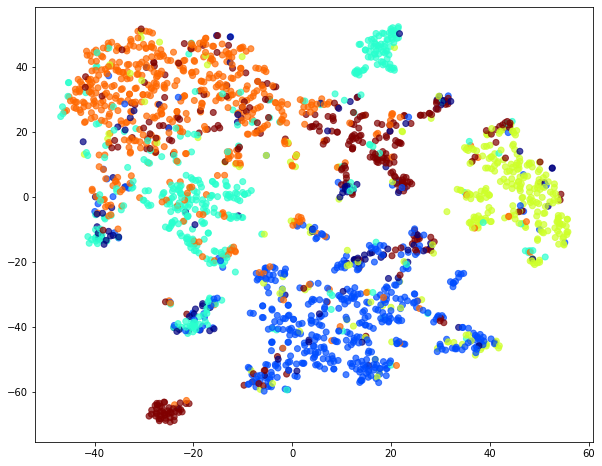

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(x)

alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(y))}
node_colours = [label_map[target] for target in y]

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)

print('fl-micro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_micro', cv=10)), 3))
print('f1-macro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_macro', cv=10)), 3))


fl-micro: 0.686
f1-macro: 0.605


In [13]:
lbe = preprocessing.LabelBinarizer()
targets = lbe.fit_transform(y)

# choose a random set of training nodes by permuting the labels and taking the first 300.
shuffled_idx = np.random.permutation(targets.shape[0])
train_node_idx = shuffled_idx[:500]
test_node_idx = shuffled_idx[500:]

training_labels = targets.copy()
training_labels[test_node_idx] = 0

d = x.shape[1] // 2

predictions = np.dot(np.exp(np.dot(x[:, :d], x[:, d:].transpose())), training_labels)

np.mean(np.argmax(predictions[test_node_idx], 1) == np.argmax(targets[test_node_idx], 1))


0.17888198757763976